In [820]:

# import libraries
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import math
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [821]:
# Read data
df = pd.read_json('data/mini_sparkify_event_data.json', orient='records', lines=True)
df.head(5)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352117000,30,29,NextSong,Logged In,PUT,200,paid,50,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Martha Tilston,Rockpools,277.89016
1,1538352180000,9,8,NextSong,Logged In,PUT,200,free,79,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Five Iron Frenzy,Canada,236.09424
2,1538352394000,30,29,NextSong,Logged In,PUT,200,paid,51,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Adam Lambert,Time For Miracles,282.82730
3,1538352416000,9,8,NextSong,Logged In,PUT,200,free,80,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Enigma,Knocking On Forbidden Doors,262.71302
4,1538352676000,30,29,NextSong,Logged In,PUT,200,paid,52,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Daft Punk,Harder Better Faster Stronger,223.60771



## Data Wrangling

In [822]:
# Drop anonymous
df = df[df['userId'] != '']

# convert userid type from string to numeric
df['userId'] = df['userId'].astype('int')

In [967]:
# custom function for lambda. convert raw numeric timestamp to datetime format.
def convert_ts(x):
    return datetime.utcfromtimestamp(int(x) / 1000)

In [824]:
# Add event log datetime column. (human readable format) based on ts column
df['datetime'] = df.ts.apply(convert_ts)

# Add user registration datetime column. For later tenure calculation.
df['reg'] = df['registration'].apply(convert_ts)

In [825]:
# Custom lambda function. Convert useragent to device
def convert_ua(x):
    user_os = x.lower().split('/')[1]

    if 'windows' in user_os:
        x = 'Windows'
    elif 'macintosh' in user_os:
        x = 'MacOS'
    elif 'iphone' in user_os:
        x = 'iOS'
    elif 'ipad' in user_os:
        x = 'iOS'
    elif 'linux' in user_os:
        x = 'Linux'
    else:
        x = 'Others'

    return x

# Create device column
df['device'] = df['userAgent'].apply(convert_ua)

In [826]:
# Custom lambda function. Convert location to region
# To 4 main regions.
# https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States#/media/File:Census_Regions_and_Division_of_the_United_States.svg

def convert_location(x):
    west = ['wa', 'or', 'ca', 'az', 'nm', 'co', 'wy', 'mt', 'id', 'nv', 'ut', 'ak']
    midwest = ['nd', 'sd', 'ne', 'ks', 'mn', 'ia', 'mo', 'wi', 'il', 'in', 'mi', 'oh']
    northeast = ['pa', 'ny', 'nj', 'vt', 'ma', 'ct', 'nh', 'ri', 'me']
    south = ['tx', 'ok', 'ar', 'la', 'ms', 'ky', 'tn', 'al', 'ga', 'fl', 'wv', 'va', 'nc', 'sc', 'dc', 'md', 'de']

    x = x.lower().split(',')[1][1:3]

    if x in west:
        region = 'West'
    elif x in midwest:
        region = 'Midwest'
    elif x in northeast:
        region = 'Northeast'
    elif x in south:
        region = 'South'
    else:
        region = 'Others'

    return region

# Create region column
df['region'] = df['location'].apply(convert_location)

In [827]:
# Check http status code percentage

df['status'].value_counts() / df['status'].value_counts().sum()

# There very are minor 404 error event. Ignore.

200    0.915745
307    0.083350
404    0.000906
Name: status, dtype: float64

## Measureing Churn

In [828]:
# Number of all distinct users
n_users = df['userId'].nunique()
print(f"Number of all distinct users: {n_users}")

# variable to hold distinct user ids
all_user_ids = sorted(df['userId'].value_counts().index.to_list())

# Number of 'paid' level users
n_paid_users = df[df['level'] == 'paid']['userId'].nunique()
print(f"Number of paid users: {n_paid_users}")

# List of 'paid' users IDs. Sorted list with numeric order for consistency.
paid_user_ids = sorted(df[df['level'] == 'paid']['userId'].value_counts().index.to_list())

# List of 'free' users IDs. Sorted list with numeric order for consistency.
free_user_ids = sorted(df[~df['userId'].isin(paid_user_ids)]['userId'].value_counts().index.to_list())
n_free_users = len(free_user_ids)
print(f"Number of free users: {n_free_users}")


225

In [834]:
# List of churn users

churn_user_ids = sorted(df[df['auth'] == 'Cancelled']['userId'].value_counts().index.to_list())
n_churn_users = len(churn_user_ids)
print(f"Number of Churn Users: {n_churn_users}")

# List of retain users
retain_user_ids = list(set(all_user_ids) - set(churn_user_ids))
n_retain_users = len(retain_user_ids)
print(f"Number of Retain Users: {n_retain_users}")

Number of Churn Users: 52


In [835]:
# Number of churn users in different subscription levels

df[df['auth'] == 'Cancelled'].groupby('level').size()

level
free    21
paid    31
dtype: int64

In [969]:
# Overall Total Churn Rate.
# Total number of churn users / total number of users

churn_rate_all = n_churn_users / n_users
print(f"Churn rate within all users: {round(churn_rate_all, 2)}")


# Free users churn rate
# total number of churn users who are 'free-tier' / total number of free users

churn_rate_free = df[df['auth'] == 'Cancelled'].groupby('level').size()['free'] / n_free_users
print(f"Churn rate within free-tier users: {round(churn_rate_free, 2)}")


# Paid users churn rate
# total number of churn users who are  'paid-tier' / total number of paid users

churn_rate_paid = df[df['auth'] == 'Cancelled'].groupby('level').size()['paid'] / n_paid_users
print(f"Churn rate within paid-tier users: {round(churn_rate_paid, 2)}")

Churn rate within all users: 0.23
Churn rate within free-tier users: 0.35
Churn rate within paid-tier users: 0.19


In [839]:
# Spot Check: Event log earliest date and date in the dataset
print(np.min(df['datetime']))
print(np.max(df['datetime']))

# Days within range in the dataset
print(np.max(df['datetime']) - np.min(df['datetime']))

2018-10-01 00:01:57
2018-12-03 01:11:16
63 days 01:09:19
2018-03-18 13:44:35
2018-11-26 15:49:14


In [ ]:
# Spot Check: earliest date and latest user registration date in the dataset
print(np.min(df['reg']))
print(np.max(df['reg']))

In [840]:
# Out of curiosity. on what day people tend to use the service to stream music? (Day of Week)

df_day_name = df.query("page == 'NextSong'").drop_duplicates(['userId', 'sessionId'])[['datetime']]
df_day_name['day_name'] = df_day_name['datetime'].apply(lambda x: x.day_name())

px.histogram(df_day_name,
             x="day_name",
             nbins=20,
             width=600,
             opacity=0.6,
             labels={'day_name': 'Day of Week'},
             title='Histogram of distribution of song play session of day of week',
             ).show()

# It is kind of surprising that I though for consumer product service like music,movie play, weekend expect more. However, the data plot
# reveals Sparkify user play more on the weekdays.

<a id='features-engineering'></a>
## Features Engineering (Metrics Design)

Feature: Tenure Days Check

In [841]:
# Calculate tenure days for a given user

def get_tenure(user_id):
    # timedelta
    td = df[df['userId'] == user_id].iloc[-1]['datetime'] - df[df['userId'] == user_id].iloc[0]['reg']
    return td.days


In [842]:
# Get tenure days for users

list_tenure_all = [get_tenure(x) for x in all_user_ids]
list_tenure_churn = [get_tenure(x) for x in churn_user_ids]
list_tenure_retain = [get_tenure(x) for x in retain_user_ids]
list_tenure_paid = [get_tenure(x) for x in paid_user_ids]
list_tenure_free = [get_tenure(x) for x in free_user_ids]

# Assemble to a dict to later look up.
dict_tenure_all = dict(zip(all_user_ids, list_tenure_all))

In [843]:
# Visualize the tenure days difference for churn and retain users.

df_tenure_check = pd.DataFrame({
    'churn': ['Churn', 'Retain'],
    'tenure': [np.mean(list_tenure_churn), np.mean(list_tenure_retain)]
})

df_tenure_check = df_tenure_check.set_index('churn')
df_tenure_check

,tenure
churn,
Churn,56.807692
Retain,86.144509


In [844]:
px.bar(df_tenure_check,
       x=df_tenure_check.index,
       y='tenure',
       title='average tenure days for churn, retain users'.title(),
       width=450,
       opacity=0.6
       )

# Plot shows churn user have relatively less tenure days. Metric: tenure

Feature: UserAgent Check

In [845]:
# Check for categorical data: is UserAgent Device a matter to Churn?

df_device_churn = df[df.userId.isin(churn_user_ids)].drop_duplicates('userId')['device'].value_counts().reset_index()
df_device_churn.columns = ['device', 'n_churn_device']

df_device_all = df[df.userId.isin(all_user_ids)].drop_duplicates('userId')['device'].value_counts().reset_index()
df_device_all.columns = ['device', 'n_all_device']

df_device_check = pd.merge(
    df_device_churn,
    df_device_all,
    how='inner',
    on='device'
)

df_device_check['perc'] = df_device_check['n_churn_device'] / df_device_check['n_all_device']
df_device_check

,device,n_churn_device,n_all_device,perc
0,Windows,24,111,0.216216
1,MacOS,19,86,0.220930
2,Linux,5,12,0.416667
3,iOS,4,16,0.250000


In [846]:
# Plot
fig = px.bar(df_device_check,
             x='device',
             y='perc',
             width=600,
             title="Device Churn Percentage Comparison.".title(),
             labels={'device': 'Device', 'perc': 'Percentage'},
             color='device'
             )
fig.show()

# It seems that Linux user has a more churn perc. However, the instances of Linux is limited. Not sure is by chance or not, it will become more clear when we
# have more Linux user data. For the mini set, we will include into training anyway. (Note that there is a risk of over-fitting due to the few instances)
# Hypothesis: Users that using Linux version of the product is more likely to churn. Metric: is_linux

Feature: Location Check

In [847]:
# Check for categorical data: is LOCATION REGION a matter to Churn?

# Churn user region perc
# NOTE that it is NOT necessary to say south users are more likely to churn. Might just be proportional to user bases. No evidence.
df_region_perc_churn = pd.DataFrame(
    df[df.userId.isin(churn_user_ids)].drop_duplicates('userId').region.value_counts() /
    np.sum(df[df.userId.isin(churn_user_ids)].drop_duplicates('userId').region.value_counts())
).reset_index()

df_region_perc_churn.columns = ['region', 'perc']
df_region_perc_churn = df_region_perc_churn.sort_values('region')

df_region_perc_all = pd.DataFrame(
    df.drop_duplicates('userId').region.value_counts() /
    np.sum(df.drop_duplicates('userId').region.value_counts())
).reset_index()

df_region_perc_all.columns = ['region', 'perc']
df_region_perc_all = df_region_perc_all.sort_values('region')

df_region_perc_check = pd.merge(df_region_perc_churn, df_region_perc_all, how="inner", on='region')
df_region_perc_check.columns = ['region', 'churn_base', 'all_base']

df_region_perc_check

,region,churn_base,all_base
0,Midwest,0.192308,0.164444
1,Northeast,0.153846,0.208889
2,South,0.384615,0.360000
3,West,0.269231,0.266667


In [848]:
# Plot
fig = px.bar(df_region_perc_check,
             x='region',
             y=['churn_base', 'all_base'],
             barmode='group',
             width=800,
             title="user percentage in region for churn and all user.".title(),
             labels={'region': 'Region', 'value': 'Percentage'}
             )
fig.show()

# They are rather proportional. There is no typical evidence that region is factor of churn.

Feature: Gender check

In [849]:
# Check for categorical data: is GENDER a matter to Churn?

# Churn user gender perc
df_gender_perc_churn = \
    df[df.userId.isin(churn_user_ids)].drop_duplicates('userId').gender.value_counts() / np.sum(df[df.userId.isin(churn_user_ids)].drop_duplicates('userId').gender.value_counts())

# All user gender perc
df_gender_perc_all = df.drop_duplicates('userId').gender.value_counts() / np.sum(
    df.drop_duplicates('userId').gender.value_counts())

# Merge
df_gender_perc_check = pd.merge(df_gender_perc_churn, df_gender_perc_all, how='inner', on=df_gender_perc_churn.index)
df_gender_perc_check.columns = (['gender', 'churn_base', 'all_base'])
df_gender_perc_check

,gender,churn_base,all_base
0,M,0.615385,0.537778
1,F,0.384615,0.462222


In [850]:
# Plot
fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_gender_perc_check['gender'],
    y=df_gender_perc_check['churn_base'],
    marker_color='indianred',
    name='Churn Base',
    base=0
))

fig.add_trace(go.Bar(
    x=df_gender_perc_check['gender'],
    y=df_gender_perc_check['all_base'],
    hovertext=df_gender_perc_check['all_base'],
    marker_color='lightsalmon',
    name='All Base',
    base=-1
))

fig.update_layout(barmode='relative',
                  width=400,
                  height=500,
                  title="Relative Gender Percentage Compare",
                  )

fig.update_yaxes(visible=False)

fig.show()

In [851]:
# Another way to visualize the gender.

fig = go.Figure()

fig.add_trace(go.Bar(
    x=['Churn Base', 'All Base'],
    y=df_gender_perc_check.iloc[0].values[1:],
    marker_color='lightslategrey',
    name='Male',
))

fig.add_trace(go.Bar(
    x=['Churn Base', 'All Base'],
    y=df_gender_perc_check.iloc[1].values[1:],
    marker_color='hotpink',
    name='Female',
))

fig.update_layout(barmode='group',
                  width=400,
                  height=500,
                  title="Relative Gender Percentage Compare",
                  yaxis=dict(
                      title='Percentage',
                      titlefont_size=16,
                      tickfont_size=14),
                  xaxis=dict(
                      title="Comparison Base")
                  )

fig.show()

# Hypothesis: male are relatively more likely to churn than female. Metric: is_male

Feature: Level check

In [852]:
# Churn rate for free-tier users vs paid-tier users.

fig = go.Figure([go.Bar(
    marker_color=['lightslategray', 'gold'],
    x=['Free-Tier', 'Paid-Tier'],
    y=[churn_rate_free, churn_rate_paid])])

fig.update_layout(
    width=500,
    height=600,
    title_text="Churn rate for different level of users"
)

fig.show()

# Hypothesis: Free-tier user churn at a more significant rate. Paid-tier users has more 'loyalty' for the service. Metric: is_free

Features: All kinds of events.

In [853]:
# Check all kinds of events logged.

df['page'].value_counts()

NextSong                     228108
Thumbs Up                     12551
Home                          10082
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Settings                       1514
Help                           1454
Upgrade                         499
About                           495
Save Settings                   310
Error                           252
Submit Upgrade                  159
Submit Downgrade                 63
Cancel                           52
Cancellation Confirmation        52
Name: page, dtype: int64

In [854]:
# Song play count avg.
# Retain user avg play significantly more songs
# Hypothesis: retain users play more songs. # This is the Primary metric. Metric: n_play

print(df[df['userId'].isin(churn_user_ids)].query("page == 'NextSong'").shape[0] / n_churn_users)
print(df[df['userId'].isin(retain_user_ids)].query("page == 'NextSong'").shape[0] / n_retain_users)

699.8846153846154
1108.1734104046243


In [855]:
# Like avg.
# Hypothesis: retain user hit 'like' more. Metric: n_like

print(df[df['userId'].isin(churn_user_ids)].query("page == 'Thumbs Up'").shape[0] / n_churn_users)
print(df[df['userId'].isin(retain_user_ids)].query("page == 'Thumbs Up'").shape[0] / n_retain_users)

35.75
61.80346820809248


In [856]:
# Dislike avg. Not much difference. But we will test out. It may relate to engagement. Metric: n_dislike

print(df[df['userId'].isin(churn_user_ids)].query("page == 'Thumbs Down'").shape[0] / n_churn_users)
print(df[df['userId'].isin(retain_user_ids)].query("page == 'Thumbs Down'").shape[0] / n_retain_users)

9.538461538461538
11.84971098265896


In [857]:
# Add to Playlist avg.  Yes diff.
# Hypothesis: retain user add more songs to playlist. Metric: n_addtolist

print(df[df['userId'].isin(churn_user_ids)].query("page == 'Add to Playlist'").shape[0] / n_churn_users)
print(df[df['userId'].isin(retain_user_ids)].query("page == 'Add to Playlist'").shape[0] / n_retain_users)

19.96153846153846
31.722543352601157


In [858]:
# Add Friend avg. Yes diff
# Hypothesis: retain user add more friends. n_friend

print(df[df['userId'].isin(churn_user_ids)].query("page == 'Add Friend'").shape[0] / n_churn_users)
print(df[df['userId'].isin(retain_user_ids)].query("page == 'Add Friend'").shape[0] / n_retain_users)

12.23076923076923
21.046242774566473


In [859]:
# Home page viewing avg. diff. churn user visit homepage less. retain more frequent to check home page.
# However, is homepage visit really matter to engagement or service utilization? I am reluctant to use it. Pass

print(df[df['userId'].isin(churn_user_ids)].query("page == 'Home'").shape[0] / n_churn_users)
print(df[df['userId'].isin(retain_user_ids)].query("page == 'Home'").shape[0] / n_retain_users)

32.15384615384615
48.61271676300578


In [860]:
# Ad viewing avg. Similar frequency.  not much diff. pass.

print(df[df['userId'].isin(churn_user_ids)].query("page == 'Roll Advert'").shape[0] / n_churn_users)
print(df[df['userId'].isin(retain_user_ids)].query("page == 'Roll Advert'").shape[0] / n_retain_users)

18.596153846153847
17.14450867052023


In [861]:
# logout avg. yes diff, BUT retain user logout more doesnt make much sense. also note very few results. pass.

print(df[df['userId'].isin(churn_user_ids)].query("page == 'Logout'").shape[0] / n_churn_users)
print(df[df['userId'].isin(retain_user_ids)].query("page == 'Logout'").shape[0] / n_retain_users)

10.634615384615385
15.45086705202312


In [862]:
# Downgrade page viewing avg. not much diff. and not relate to engagement, utilization. pass.

print(df[df['userId'].isin(churn_user_ids)].query("page == 'Downgrade'").shape[0] / n_churn_users)
print(df[df['userId'].isin(retain_user_ids)].query("page == 'Downgrade'").shape[0] / n_retain_users)

6.480769230769231
9.93063583815029


In [863]:
# Submit downgrade avg. yes diff . but very few instances, include will more likely to over-fit. pass

print(df[df['userId'].isin(churn_user_ids)].query("page == 'Submit Downgrade'").shape[0] / n_churn_users)
print(df[df['userId'].isin(retain_user_ids)].query("page == 'Submit Downgrade'").shape[0] / n_retain_users)

0.17307692307692307
0.31213872832369943


In [864]:
# Help page view avg. not much diff. pass. include will more likely to over-fit. pass
# Again, We really should focus on metrics relate to engagement and utilization.

print(df[df['userId'].isin(churn_user_ids)].query("page == 'Help'").shape[0] / n_churn_users)
print(df[df['userId'].isin(retain_user_ids)].query("page == 'Help'").shape[0] / n_retain_users)

4.596153846153846
7.023121387283237


- Categorical data (Nominal Data), select is_linux, is_male, is_free
- Discrete data aggregation, select relate to user engagement, service utilization, and are showing some diff. things like song, like, dislike, playlist, session, homepage ...
- Continuous data, for example playback length.

In [865]:
# Helper Functions. To extract categorical value later for analytic dataset.

def get_is_male(user_id):
    gender = df[df['userId'] == user_id].iloc[0]['gender']
    return 1 if gender.lower() == 'm' else 0


def get_is_linux(user_id):
    device = df[df['userId'] == user_id].iloc[0]['device']
    return 1 if device.lower() == 'linux' else 0


def get_is_free(user_id):
    return 1 if user_id in free_user_ids else 0


### Creating analytic dataset and add metrics

In [866]:
# Create a analytic helper dataset. Having all user ids.
# We will concat metrics dataset for each user into one later.

df_analytic = pd.DataFrame({'userId': all_user_ids})
df_analytic.head()

,userId
0,2
1,3
2,4
3,5
4,6


In [867]:
# Double Check if there are any event after user's cancel, may create confusion for model. Trim them if there are any.

churn_ids_and_times = df[df.auth == 'Cancelled'][['userId', 'datetime']].to_numpy()

n_event_after_churn = 0

for i in churn_ids_and_times:
    user_id = i[0]
    dt = i[1]
    idx = df[(df.userId == user_id) & (df.datetime > dt)].index
    n_event_after_churn += len(idx)

print(n_event_after_churn)

# Users have No event after cancel.

0


n_session:

In [868]:
# Total number of sessions for each user.

df_n_session = pd.DataFrame(df.groupby(['userId', 'sessionId']).size()).reset_index().drop(
    [0], axis=1)

df_n_session = pd.DataFrame(df_n_session.groupby(['userId'])['sessionId'].count()).reset_index()

df_n_session.columns = ['userId', 'n_session']

# Outer Join to make sure retain all user ids
df_n_session = pd.merge(
    df_analytic,
    df_n_session,
    how='outer',
    on='userId'
)

df_n_session.head(3)

,userId,n_session
0,2,7
1,3,4
2,4,22


In [869]:
# Overview of distribution of the number sessions

px.histogram(df_n_session,
             x="n_session",
             nbins=20,
             width=600,
             opacity=0.6,
             labels={'n_session': 'Number of Sessions'},
             title='Histogram of distribution of n_session',
).show()


n_item:

In [870]:
# n_item
# Total number of items in session for each user

df_n_item = df.query("page == 'NextSong'").sort_values(by='userId').groupby(['userId', 'sessionId'])[
    'itemInSession'].max().reset_index().groupby('userId')['itemInSession'].sum().reset_index()

df_n_item.columns = ['userId', 'n_item']

# Outer Join to make sure retain all user ids
df_n_item = pd.merge(
    df_analytic,
    df_n_item,
    how='outer',
    on='userId'
)

df_n_item.head(3)

,userId,n_item
0,2,904
1,3,251
2,4,2456


total_length

In [871]:
# total_length
# Total song playing length (duration) for each user.

df_total_length = df.groupby(['userId'])['length'].sum().reset_index()

df_total_length.columns = ['userId', 'total_length']

# Outer Join to make sure retain all user ids
df_total_length = pd.merge(
    df_analytic,
    df_total_length,
    how='outer',
    on='userId'
)

df_total_length.head(3)

,userId,total_length
0,2,188687.38342
1,3,54424.74544
2,4,506140.04138


n_play

In [872]:
# n_play
# Total number of song play event for each user.

df_n_play = df.query("page == 'NextSong'").groupby(['userId']).size().reset_index()

df_n_play.columns = ['userId', 'n_play']

# Outer Join to make sure retain all user ids
df_n_play = pd.merge(
    df_analytic,
    df_n_play,
    how='outer',
    on='userId'
)

df_n_play.head(3)

,userId,n_play
0,2,755
1,3,214
2,4,2048


n_like

In [873]:
# n_like
# Total number of like event for each user.

df_n_like = df.query("page == 'Thumbs Up'").groupby(['userId']).size().reset_index()
df_n_like.columns = ['userId', 'n_like']

# Outer Join to make sure retain all user ids
df_n_like = pd.merge(
    df_analytic,
    df_n_like,
    how='outer',
    on='userId'
)

df_n_like.head(3)

,userId,n_like
0,2,29.0
1,3,14.0
2,4,95.0


n_dislike

In [875]:
# n_dislike
# Total number of dislike event for each user.

df_n_dislike = df.query("page == 'Thumbs Down'").groupby(['userId']).size().reset_index()
df_n_dislike.columns = ['userId', 'n_dislike']

# Outer Join to make sure retain all user ids
df_n_dislike = pd.merge(
    df_analytic,
    df_n_dislike,
    how='outer',
    on='userId'
)

df_n_dislike.head(3)

,userId,n_dislike
0,2,6.0
1,3,3.0
2,4,26.0


n_addtolist

In [877]:
# n_addtolist
# Total number of Add to Playlist event for each user.

df_n_addtolist = df.query("page == 'Add to Playlist'").groupby(['userId']).size().reset_index()
df_n_addtolist.columns = ['userId', 'n_addtolist']

# Outer Join to make sure retain all user ids
df_n_addtolist = pd.merge(
    df_analytic,
    df_n_addtolist,
    how='outer',
    on='userId'
)

df_n_addtolist.head(3)

,userId,n_addtolist
0,2,13.0
1,3,4.0
2,4,59.0


n_addfriend

In [878]:
# n_addfriend
# Total number of Add Friend event for each user.

df_n_addfriend = df.query("page == 'Add Friend'").groupby(['userId']).size().reset_index()
df_n_addfriend.columns = ['userId', 'n_addfriend']

# Outer Join to make sure retain all user ids
df_n_addfriend = pd.merge(
    df_analytic,
    df_n_addfriend,
    how='outer',
    on='userId'
)

df_n_addfriend.head(3)

,userId,n_addfriend
0,2,20.0
1,3,1.0
2,4,46.0


n_artist

In [879]:
# n_artist
# Number of distinct artists listened for each user.

df_n_artist = df[~df.artist.isnull()].groupby(['userId', 'artist']).size().reset_index().groupby(['userId'])[
    'artist'].count().reset_index()

df_n_artist.columns = ['userId', 'n_artist']

# Outer Join to make sure retain all user ids
df_n_artist = pd.merge(
    df_analytic,
    df_n_artist,
    how='outer',
    on='userId'
)

df_n_artist.head(3)

,userId,n_artist
0,2,587
1,3,197
2,4,1342


n_home

In [880]:
# n_home
# Number of Home page visited for each user.

df_n_home = df.query("page == 'Home'").groupby(['userId']).size().reset_index()
df_n_home.columns = ['userId', 'n_home']

# Outer Join to make sure retain all user ids
df_n_home = pd.merge(
    df_analytic,
    df_n_home,
    how='outer',
    on='userId'
)

df_n_home.head(3)

,userId,n_home
0,2,35.0
1,3,8.0
2,4,80.0


n_tenure

In [881]:
# n_tenure
# Number of tenure days for each user.

df_n_tenure = pd.DataFrame({
    'userId': all_user_ids,
    'tenure': list_tenure_all
})

# Outer Join to make sure retain all user ids
df_n_tenure = pd.merge(
    df_analytic,
    df_n_tenure,
    how='outer',
    on='userId'
)

df_n_tenure.head(3)

,userId,tenure
0,2,69
1,3,80
2,4,62


ratio_length_per_session

In [882]:
# ratio: length_per_session
# Duration of song playing per session for each user.

df_ratio_length_per_session = pd.merge(
    # Join data. Retain all possible users ids with outer join.
    # Outer Join guarantee to have all keys on left table.
    pd.merge(df_analytic, df_total_length, how='outer', on='userId'),
    df_n_session, how='outer', on='userId'
)

df_ratio_length_per_session['ratio_length_per_session'] = \
    df_ratio_length_per_session['total_length'] / df_ratio_length_per_session['n_session']

df_ratio_length_per_session.head(3)


,userId,total_length,n_session,ratio_length_per_session
0,2,188687.38342,7,26955.340489
1,3,54424.74544,4,13606.186360
2,4,506140.04138,22,23006.365517


ratio_addtolist_per_play

In [883]:
# ratio_addtolist_per_play
# Number of AddToPlayList action per song play for each user.

df_ratio_addtolist_per_play = pd.merge(
    # Join data. Retain all possible users ids with outer join.
    # Outer Join guarantee to have all keys on left table.
    pd.merge(df_analytic, df_n_addtolist, how='outer', on='userId'),
    df_n_play, how='outer', on='userId'
)

df_ratio_addtolist_per_play['ratio_addtolist_per_play'] = df_ratio_addtolist_per_play.n_addtolist / df_ratio_addtolist_per_play.n_play

df_ratio_addtolist_per_play.head(3)

,userId,n_addtolist,n_play,ratio_addtolist_per_play
0,2,13.0,755,0.017219
1,3,4.0,214,0.018692
2,4,59.0,2048,0.028809


ratio_like_per_play

In [884]:
# ratio_like_per_play
# Number of like per song play for each user.

df_ratio_like_per_play = pd.merge(
    # Join data. Retain all possible users ids with outer join.
    # Outer Join guarantee to have all keys on left table.
    pd.merge(df_analytic, df_n_like, how='outer', on='userId'),
    df_n_play, how='outer', on='userId'
)

df_ratio_like_per_play['ratio_like_per_play'] = df_ratio_like_per_play.n_like / df_ratio_like_per_play.n_play

df_ratio_like_per_play.head(3)

,userId,n_like,n_play,ratio_like_per_play
0,2,29.0,755,0.038411
1,3,14.0,214,0.065421
2,4,95.0,2048,0.046387


ratio_dislike_per_play

In [886]:
# ratio_dislike_per_play
# Number of dislike per song play

df_ratio_dislike_per_play = pd.merge(
    # Join data. Retain all possible users ids with outer join.
    # Outer Join guarantee to have all keys on left table.
    pd.merge(df_analytic, df_n_dislike, how='outer', on='userId'),
    df_n_play, how='outer', on='userId'
)

df_ratio_dislike_per_play[
    'ratio_dislike_per_play'] = df_ratio_dislike_per_play.n_dislike / df_ratio_dislike_per_play.n_play

df_ratio_dislike_per_play.head(3)

,userId,n_dislike,n_play,ratio_dislike_per_play
0,2,6.0,755,0.007947
1,3,3.0,214,0.014019
2,4,26.0,2048,0.012695


Change measurement on primary metrics (n_play, total_length)

In [887]:
# Change measurement on primary feature
# define datetime range for cycle comparison

interval = pd.Timedelta('28 days')

datetime_latest_to = pd.Timestamp('2018-12-03')
datetime_latest_from = pd.Timestamp('2018-12-03') - interval

datetime_previous_to = datetime_latest_from
datetime_previous_from = datetime_previous_to - interval

print(f"Latest Cycle vs Previous Cycle")
print(f"Each measurement cycle is 28 days duration.")
print(f"Latest Cycle: [{datetime_latest_from} - {datetime_latest_to})")
print(f"Previous Cycle: [{datetime_previous_from} - {datetime_previous_to})")

Latest Cycle vs Previous Cycle
Each measurement cycle is 28 days duration.
Latest Cycle: [2018-11-05 00:00:00 - 2018-12-03 00:00:00)
Previous Cycle: [2018-10-08 00:00:00 - 2018-11-05 00:00:00)


change_perc_n_play

In [888]:
# Change: Change of total song play percentage for two periods.

# df[(df.page == 'NextSong') & (df.datetime >= datetime_previous_from) & (df.datetime < datetime_previous_to)].groupby(['userId']).size().reset_index()
# df[(df.page == 'NextSong') & (df.datetime >= datetime_latest_from) & (df.datetime < datetime_latest_to)].groupby(['userId']).size().reset_index()


df_change_perc_n_play = pd.merge(
    left=df_analytic,
    right=df[(df.page == 'NextSong') & (df.datetime >= datetime_previous_from) & (
            df.datetime < datetime_previous_to)].groupby(['userId']).size().reset_index(),
    how='left',
    on='userId'
)

df_change_perc_n_play = pd.merge(
    left=df_change_perc_n_play,
    right=df[
        (df.page == 'NextSong') & (df.datetime >= datetime_latest_from) & (df.datetime < datetime_latest_to)].groupby(
        ['userId']).size().reset_index(),
    how='left',
    on='userId'
)

df_change_perc_n_play.columns = ['userId', 'previous', 'latest']

df_change_perc_n_play['change_perc_n_play'] = (df_change_perc_n_play['latest'] - df_change_perc_n_play[
    'previous']) / df_change_perc_n_play['previous']

df_change_perc_n_play.head(5)

,userId,previous,latest,change_perc_n_play
0,2,508.0,247.0,-0.513780
1,3,192.0,NaN,NaN
2,4,1004.0,1025.0,0.020916
3,5,107.0,54.0,-0.495327
4,6,1818.0,1219.0,-0.329483


change_perc_total_length

In [889]:
# Change: change of total playback duration for two periods

# df[(df.datetime >= datetime_previous_from) & (df.datetime < datetime_previous_to)].groupby(['userId'])['length'].sum()
# df[(df.datetime >= datetime_latest_from) & (df.datetime < datetime_latest_to)].groupby(['userId'])['length'].sum()

df_change_perc_total_length = pd.merge(
    left=df_analytic,
    right=df[(df.datetime >= datetime_previous_from) & (df.datetime < datetime_previous_to)].groupby(['userId'])[
        'length'].sum(),
    how='left',
    on='userId'
)

df_change_perc_total_length = pd.merge(
    left=df_change_perc_total_length,
    right=df[(df.datetime >= datetime_latest_from) & (df.datetime < datetime_latest_to)].groupby(['userId'])[
        'length'].sum(),
    how='left',
    on='userId'
)

df_change_perc_total_length.columns = ['userId', 'previous', 'latest']

df_change_perc_total_length['change_perc_total_length'] = \
    (df_change_perc_total_length['latest'] - df_change_perc_total_length['previous']) / df_change_perc_total_length['previous']

df_change_perc_total_length.head(5)

,userId,previous,latest,change_perc_total_length
0,2,126562.53867,62124.84475,-0.509137
1,3,49060.74560,NaN,NaN
2,4,247629.18078,252846.11166,0.021068
3,5,25923.71308,13601.33390,-0.475332
4,6,451570.50628,303683.96646,-0.327494


Flatten the metrics dataset

In [931]:
# Flatten the analytic datasets. Concat all metrics.

df_flatten = pd.concat([df_n_play,
                        df_n_session,
                        df_n_item,
                        df_n_addtolist,
                        df_n_addfriend,
                        df_n_like,
                        df_n_dislike,
                        df_n_artist,
                        df_n_tenure,
                        df_total_length,
                        df_ratio_length_per_session,
                        df_ratio_addtolist_per_play,
                        df_ratio_like_per_play,
                        df_ratio_dislike_per_play,
                        df_change_perc_n_play,
                        df_change_perc_total_length],
                       axis=1)

In [932]:
# Reshaping, drop duplicate columns, drop unwanted columns.
# For example, during concat, it will have multiple 'userId' columns.

df_flatten = df_flatten.iloc[:, sorted(np.unique(df_flatten.columns, return_index=True)[1])]
df_flatten = df_flatten.drop(['previous', 'latest'], axis=1)

In [933]:
# Spot check flatten analytic dataset.
df_flatten.head(5)

,userId,n_play,n_session,n_item,n_addtolist,n_addfriend,n_like,n_dislike,n_artist,tenure,total_length,ratio_length_per_session,ratio_addtolist_per_play,ratio_like_per_play,ratio_dislike_per_play,change_perc_n_play,change_perc_total_length
0,2,755,7,904,13.0,20.0,29.0,6.0,587,69,188687.38342,26955.340489,0.017219,0.038411,0.007947,-0.513780,-0.509137
1,3,214,4,251,4.0,1.0,14.0,3.0,197,80,54424.74544,13606.186360,0.018692,0.065421,0.014019,NaN,NaN
2,4,2048,22,2456,59.0,46.0,95.0,26.0,1342,62,506140.04138,23006.365517,0.028809,0.046387,0.012695,0.020916,0.021068
3,5,161,6,215,8.0,3.0,11.0,NaN,154,48,39525.04698,6587.507830,0.049689,0.068323,NaN,-0.495327,-0.475332
4,6,3159,24,3813,83.0,41.0,165.0,31.0,1868,256,787236.52359,32801.521816,0.026274,0.052232,0.009813,-0.329483,-0.327494


Clean the flatten analytic dataset

In [934]:
# Missing / Empty Value Check

df_flatten.isnull().sum().sort_values(ascending=False)

change_perc_n_play          55
change_perc_total_length    54
ratio_dislike_per_play      22
n_dislike                   22
n_addfriend                 19
n_addtolist                 10
ratio_addtolist_per_play    10
n_like                       5
ratio_like_per_play          5
ratio_length_per_session     0
userId                       0
total_length                 0
tenure                       0
n_play                       0
n_item                       0
n_session                    0
n_artist                     0
dtype: int64

In [935]:
# Fill na strategy:
# For discrete data, fill with 0. those 'n_xxxx' data.
# For continuous data, fill with mean. e.g playback length, avg, ratio.
# For change percentage. (mainly because MetricEnd or MetricStart is 0, means not valid comparison). fill with 0 indicating default no change.

df_flatten['n_dislike'].fillna(0, inplace=True)
df_flatten['n_addfriend'].fillna(0, inplace=True)
df_flatten['n_addtolist'].fillna(0, inplace=True)
df_flatten['n_like'].fillna(0, inplace=True)

df_flatten['ratio_dislike_per_play'].fillna(value=df_flatten['ratio_dislike_per_play'].mean(), inplace=True)
df_flatten['ratio_addtolist_per_play'].fillna(value=df_flatten['ratio_addtolist_per_play'].mean(), inplace=True)
df_flatten['ratio_like_per_play'].fillna(value=df_flatten['ratio_like_per_play'].mean(), inplace=True)

df_flatten['change_perc_n_play'].fillna(0, inplace=True)
df_flatten['change_perc_total_length'].fillna(0, inplace=True)


In [936]:
# Check inf value

(df_flatten == np.inf).sum().sort_values(ascending=False)

change_perc_total_length    1
tenure                      0
change_perc_n_play          0
ratio_dislike_per_play      0
ratio_like_per_play         0
ratio_addtolist_per_play    0
ratio_length_per_session    0
total_length                0
userId                      0
n_play                      0
n_dislike                   0
n_like                      0
n_addfriend                 0
n_addtolist                 0
n_item                      0
n_session                   0
n_artist                    0
dtype: int64

In [937]:
# replace inf with 0

df_flatten['change_perc_total_length'].replace(np.inf, 0, inplace=True)

In [938]:
# Double check again if any missing/empty or inf value

print((df_flatten == np.inf).sum().sum())
print(df_flatten.isnull().sum().sum())

0
0


Assemble outcome label 'is_churn' to the flatten analytic dataset

In [939]:
# Add is_churn outcome label to df_flatten
df_flatten['is_churn'] = df_flatten['userId'].apply(lambda x: 1 if x in churn_user_ids else 0)

# Also store a variable hold the outcome label values
is_churn_values = df_flatten['is_churn'].values

### Metric Cohort Analysis

Analyze how churn depends on the value of metrics

In [940]:
# Plot a metric with its n cohorts, each cohort's mean value against each cohort's churn rate (mean)

def cohort_plot(metric_to_plot='', n_cohort=10, df_data=df_flatten):
    # Reference:
    # https://github.com/carl24k/fight-churn/blob/master/fightchurn/listings/chap5/listing_5_1_cohort_plot.py

    # Divide to n groups
    groups = pd.qcut(df_data[metric_to_plot], n_cohort, duplicates='drop')
    # print(groups)

    # each group's mean values as x-axis values
    cohort_means = df_data.groupby(groups)[metric_to_plot].mean()
    # print(cohort_means)

    # each group's churn rate as y-axis values
    cohort_churns = df_data.groupby(groups)['is_churn'].mean()
    # print(cohort_churns)

    plot_data = pd.DataFrame({
        metric_to_plot: cohort_means.values,
        'churn_rate': cohort_churns.values
    })

    # plot
    plt.figure(figsize=(6, 4))

    plt.plot(metric_to_plot, 'churn_rate',
             data=plot_data,
             marker='o',
             color='black',
             linewidth=2,
             label=metric_to_plot
             )

    plt.xlabel('Cohort Average of  "%s"' % metric_to_plot)
    plt.ylabel('Cohort Churn Rate')
    plt.grid()
    plt.gca().set_ylim(bottom=0)


# Plot a list of metrics.

def plot_metrics(metrics, n_cohort, df_data):
    """
    Helper Function, plot given metrics for a analytic dataset.
    """
    for metric in metrics:
        cohort_plot(metric, n_cohort=n_cohort, df_data=df_data)


First run of metric cohort analysis. (Raw metric stats, without any normalization).

First attempt of metric cohort analysis. (Without any normalization)
Getting an overall glance.

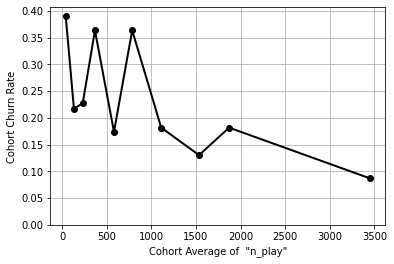

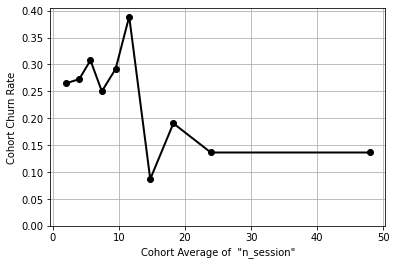

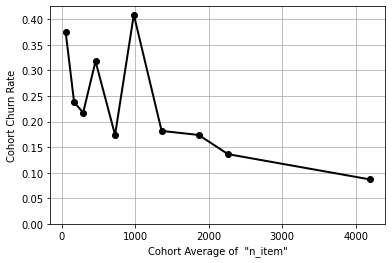

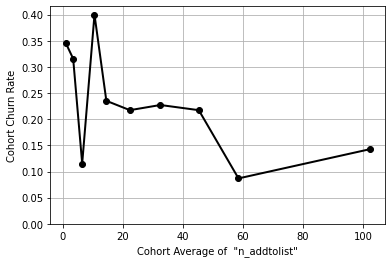

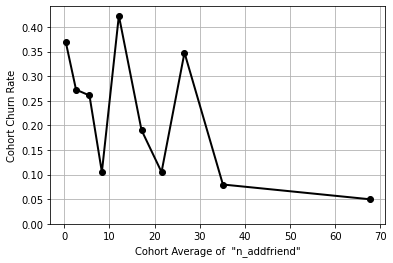

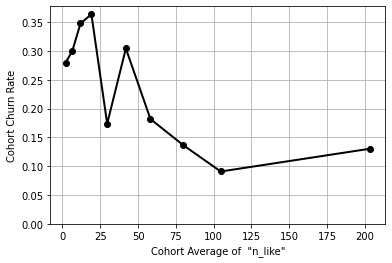

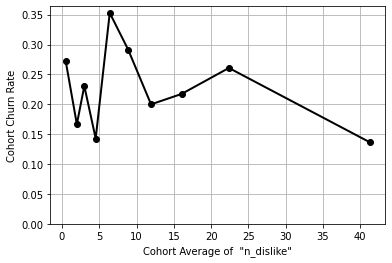

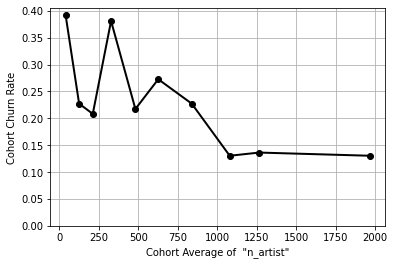

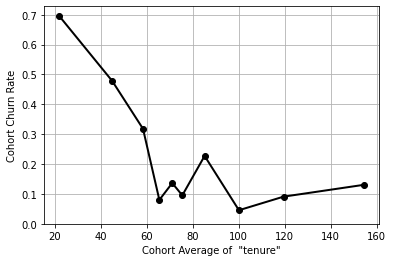

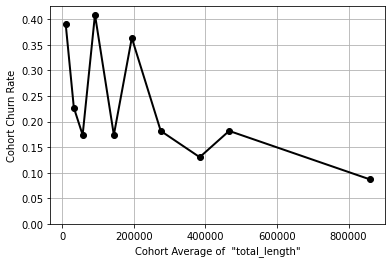

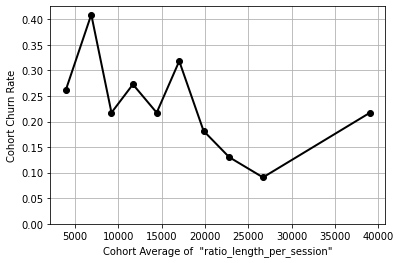

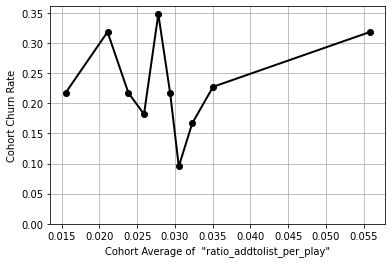

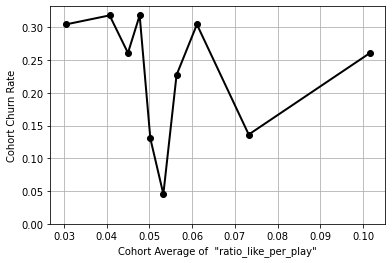

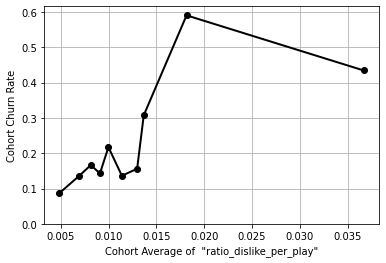

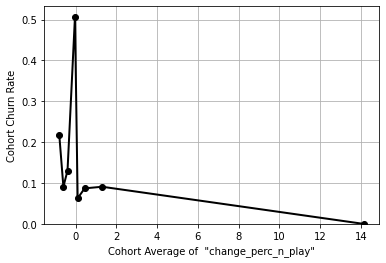

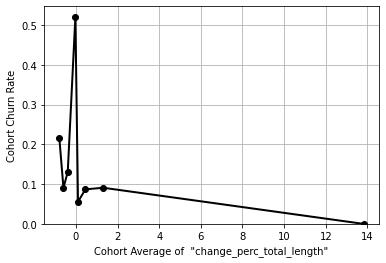

In [941]:
# First run of metric cohort analysis. (Raw stats, before any normalization)

plot_metrics(metrics=df_flatten.columns[1:-1], n_cohort=10, df_data=df_flatten)

Skewness Check

Take out some metrics if needed based on skewness check.

In [942]:
# Skew Summary Code snippet reference:
# https://github.com/carl24k/fight-churn/blob/master/fightchurn/listings/chap5/listing_5_2_dataset_stats.py


# Drop Non-metric columns
skewness_data = df_flatten.drop(['userId', 'is_churn'], axis=1)

# Transpose the describe result.
skewness_summary = skewness_data.describe()
skewness_summary = skewness_summary.transpose()

# Add skewness information
skewness_summary['skew'] = skewness_data.skew()
skewness_summary['1%'] = skewness_data.quantile(q=0.01)
skewness_summary['99%'] = skewness_data.quantile(q=0.99)
skewness_summary['nonzero'] = skewness_data.astype(bool).sum(axis=0) / skewness_data.shape[0]

skewness_summary = skewness_summary[
    ['count', 'nonzero', 'mean', 'std', 'skew', 'min', '1%', '25%', '50%', '75%', '99%', 'max']]
skewness_summary.columns = skewness_summary.columns.str.replace("%", "pct")

# skewness_summary['skew']
skewness_summary

,count,nonzero,mean,std,skew,min,1pct,25pct,50pct,75pct,99pct,max
n_play,225.0,1.000000,1013.813333,1104.960779,2.459378,3.000000,8.720000,230.000000,675.000000,1571.000000,5.413200e+03,8.002000e+03
n_session,225.0,1.000000,14.115556,14.646885,3.024384,1.000000,1.000000,6.000000,10.000000,18.000000,7.600000e+01,1.070000e+02
n_item,225.0,1.000000,1241.137778,1338.573482,2.481312,5.000000,15.200000,299.000000,841.000000,1861.000000,6.654280e+03,9.712000e+03
n_addtolist,225.0,0.955556,29.004444,32.716654,2.487561,0.000000,0.000000,6.000000,17.000000,44.000000,1.475200e+02,2.400000e+02
n_addfriend,225.0,0.915556,19.008889,20.581717,2.582252,0.000000,0.000000,5.000000,14.000000,27.000000,1.059200e+02,1.430000e+02
n_like,225.0,0.977778,55.782222,65.477925,2.655948,0.000000,0.000000,11.000000,35.000000,81.000000,3.280800e+02,4.370000e+02
n_dislike,225.0,0.902222,11.315556,13.077481,2.362149,0.000000,0.000000,2.000000,7.000000,16.000000,7.128000e+01,7.500000e+01
n_artist,225.0,1.000000,696.377778,603.951870,1.370684,3.000000,8.720000,207.000000,555.000000,1098.000000,2.740280e+03,3.544000e+03
tenure,225.0,0.995556,79.364444,37.646625,0.889579,0.000000,9.480000,59.000000,73.000000,100.000000,1.841600e+02,2.560000e+02
total_length,225.0,1.000000,252558.320652,275396.403885,2.456978,691.668840,2269.733836,57633.175640,168093.787030,392401.495000,1.347571e+06,1.991155e+06


In [943]:
# Check high skew metrics. threshold > 4

skewness_summary['skew'][skewness_summary['skew'] > 4]

ratio_addtolist_per_play     6.294848
change_perc_n_play          11.591186
change_perc_total_length    10.883710
Name: skew, dtype: float64

In [944]:
# Keep only metrics that are relative acceptable skewed. <=4

metrics_keep = list(skewness_summary['skew'][skewness_summary['skew'] <= 4].index)
metrics_keep

['n_play',
 'n_session',
 'n_item',
 'n_addtolist',
 'n_addfriend',
 'n_like',
 'n_dislike',
 'n_artist',
 'tenure',
 'total_length',
 'ratio_length_per_session',
 'ratio_like_per_play',
 'ratio_dislike_per_play']

Reselect the metrics based on acceptable skewness

In [945]:
df_flatten = df_flatten[metrics_keep]
df_flatten.head(3)

,n_play,n_session,n_item,n_addtolist,n_addfriend,n_like,n_dislike,n_artist,tenure,total_length,ratio_length_per_session,ratio_like_per_play,ratio_dislike_per_play
0,755,7,904,13.0,20.0,29.0,6.0,587,69,188687.38342,26955.340489,0.038411,0.007947
1,214,4,251,4.0,1.0,14.0,3.0,197,80,54424.74544,13606.186360,0.065421,0.014019
2,2048,22,2456,59.0,46.0,95.0,26.0,1342,62,506140.04138,23006.365517,0.046387,0.012695


Normalize Data

In [946]:
from sklearn import preprocessing

data_scaled = preprocessing.MinMaxScaler().fit_transform(df_flatten.values)

# Make a normalized version of metrics dataset.
df_normalized = pd.DataFrame(data_scaled)

# Put back outcome label column
df_normalized['is_churn'] = is_churn_values

# Update columns names
df_normalized.columns = metrics_keep + ['is_churn']

df_normalized.head()

,n_play,n_session,n_item,n_addtolist,n_addfriend,n_like,n_dislike,n_artist,tenure,total_length,ratio_length_per_session,ratio_like_per_play,ratio_dislike_per_play,is_churn
0,0.094012,0.056604,0.092614,0.054167,0.139860,0.066362,0.080000,0.164925,0.269531,0.094448,0.373086,0.106611,0.063402,0
1,0.026378,0.028302,0.025343,0.016667,0.006993,0.032037,0.040000,0.054787,0.312500,0.026995,0.183456,0.234378,0.131948,1
2,0.255657,0.198113,0.252498,0.245833,0.321678,0.217391,0.346667,0.378142,0.242188,0.253935,0.316989,0.144341,0.117008,0
3,0.019752,0.047170,0.021634,0.033333,0.020979,0.025172,0.000000,0.042643,0.187500,0.019510,0.083753,0.248108,0.122525,0
4,0.394549,0.216981,0.392294,0.345833,0.286713,0.377574,0.413333,0.526687,1.000000,0.395157,0.456134,0.171990,0.084470,0


Second round of metric cohort analysis check.
This time with normalized data and removed skewed metric.

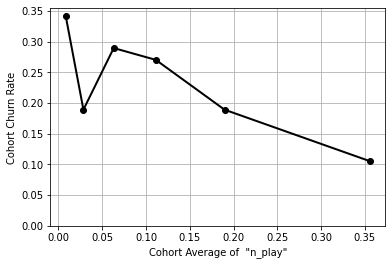

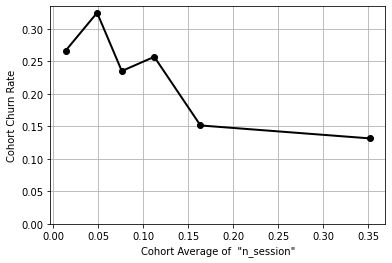

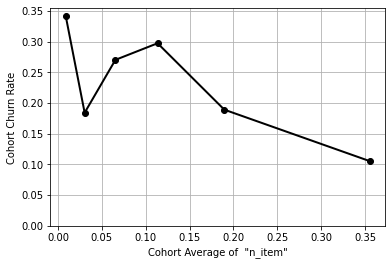

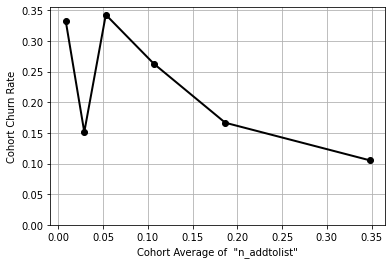

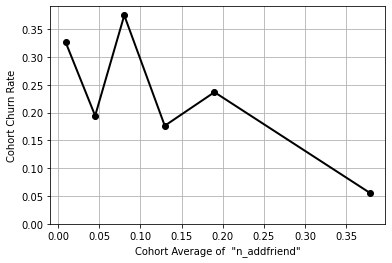

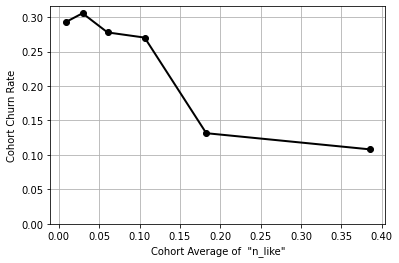

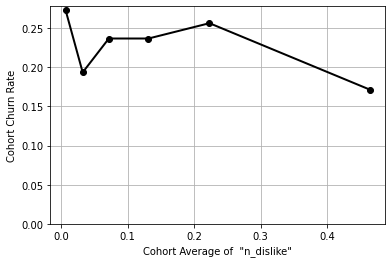

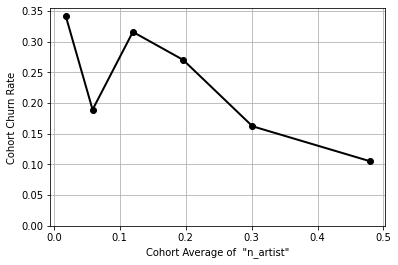

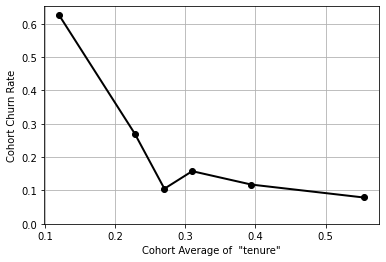

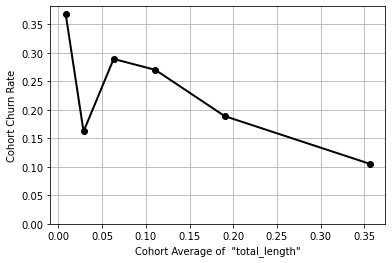

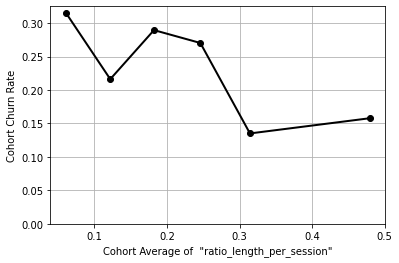

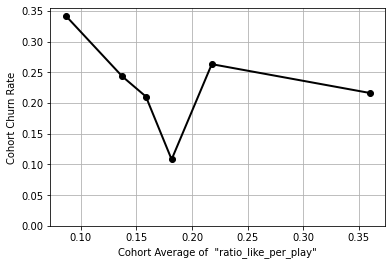

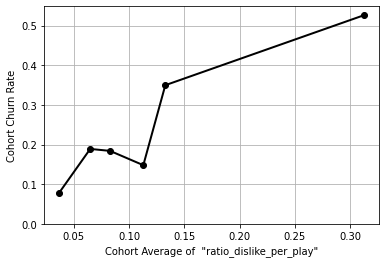

In [947]:
# Another round of cohort analysis check with normalized data, and reselect with acceptable skewed metrics.
# Also zoom out a bit. use 6 groups of cohort for each metric.

plot_metrics(metrics=df_normalized.columns[:-1], n_cohort=6, df_data=df_normalized)

In [948]:
# n_dislike, ratio_like_per_play look no pattern. Don't seem to have relationship with churn rate.
metrics_keep.remove('n_dislike')
metrics_keep.remove('ratio_like_per_play')

In [949]:
# Spot check what metrics to keep.
metrics_keep

['n_play',
 'n_session',
 'n_item',
 'n_addtolist',
 'n_addfriend',
 'n_like',
 'n_artist',
 'tenure',
 'total_length',
 'ratio_length_per_session',
 'ratio_dislike_per_play']

The final round of metric cohort analysis. After removing another round of features.

In [ ]:
# The third round of metric cohort analysis.

plot_metrics(metrics=df_normalized.columns[:-1], n_cohort=6, df_data=df_normalized)

I am satisfied with the final metric cohort analysis. Each of them do shows some degree of relationship to churn.

Now, add categorical data to the dataframe.

In [950]:
# Get categorical value. is_male, is_linux, is_free.
# These are binary categorical data. so only need one value. e.g no need to create is_male and is_female both.

df_normalized['is_male'] = df_normalized['userId'].apply(lambda x: get_is_male(x))
df_normalized['is_linux'] = df_normalized['userId'].apply(lambda x: get_is_linux(x))
df_normalized['is_free'] = df_normalized['userId'].apply(lambda x: get_is_free(x))

In [951]:
# Variable holds Metric names of categorical data
cat_metrics = ['is_male', 'is_linux', 'is_free']

In [952]:
# Re-assemble the flatten analytic data (normalized): userId + metrics_keep + categorical_metrics + outcome label

# Put back userId columns
df_normalized['userId'] = df_analytic['userId'].copy()

# Reshape the final dataset, to send to Machine Learning.
df_normalized = df_normalized[['userId'] + metrics_keep + cat_metrics + ['is_churn']]

# Spot check.
df_normalized.head(5)

,userId,n_play,n_session,n_item,n_addtolist,n_addfriend,n_like,n_artist,tenure,total_length,ratio_length_per_session,ratio_dislike_per_play,is_male,is_linux,is_free,is_churn
0,2,0.094012,0.056604,0.092614,0.054167,0.139860,0.066362,0.164925,0.269531,0.094448,0.373086,0.063402,0,0,0,0
1,3,0.026378,0.028302,0.025343,0.016667,0.006993,0.032037,0.054787,0.312500,0.026995,0.183456,0.131948,1,0,0,1
2,4,0.255657,0.198113,0.252498,0.245833,0.321678,0.217391,0.378142,0.242188,0.253935,0.316989,0.117008,1,0,0,0
3,5,0.019752,0.047170,0.021634,0.033333,0.020979,0.025172,0.042643,0.187500,0.019510,0.083753,0.122525,1,0,1,0
4,6,0.394549,0.216981,0.392294,0.345833,0.286713,0.377574,0.526687,1.000000,0.395157,0.456134,0.084470,1,0,0,0


---
## Machine Learning

### Logistic Regression

In [954]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [955]:
# Prepare independent variable (X) and dependent variable (y)

# Independent variables values. the X. (dataset that without the user id, and outcome label columns)
X = df_normalized.iloc[:, 1:-1].values

# Dependent variable. the y
y = df_normalized['is_churn'].values

In [956]:
# Create train set, test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and logistic_regression instance
log_reg = linear_model.LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)

# Train the model
log_reg.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [957]:
# Not use accuracy score, because mostly 0 value. unbalanced.
# So use f1 score.

#f1 score on train set
print(f"f1 score on train set: {f1_score(y_train, log_reg.predict(X_train), average='weighted')}")

#f1 score on test set
print(f"f1 score on test set: {f1_score(y_test, log_reg.predict(X_test), average='weighted')}")

f1 score on train set: 0.6994369057509463
f1 score on test set: 0.7295742232451093


The result of logistic regression is not very promising. I will not experiment further tuning for it in this case.

---
### XGBoost

In [958]:
import xgboost

In [959]:
# XGBoost classifier model instance
xgb_clf = xgboost.XGBRFClassifier(use_label_encoder=False)

# Train the model.
xgb_clf.fit(X_train, y_train)

[00:50:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, enable_categorical=False, gamma=0,
                gpu_id=-1, importance_type=None, interaction_constraints='',
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=12,
                num_parallel_tree=100, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact',
                use_label_encoder=False, validate_parameters=1, verbosity=None)

In [971]:
# Train set f1 score.
f1_score(y_train, xgb_clf.predict(X_train), average='weighted')

0.8949914949914949

In [960]:
# Test set f1 score.
f1_score(y_test, xgb_clf.predict(X_test), average='weighted')

0.8222222222222222

In [965]:
# GridSearch Cross Validation Tuning the model

param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

# XGBClassifier instance
xgb_cl = xgboost.XGBClassifier(objective="binary:logistic", use_label_encoder=False)

# GridSearchCV instance
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="f1_weighted")

# Train
grid_cv.fit(X_train, y_train)

[01:04:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=False,
  

In [963]:
# f1 score on train set

f1_score(grid_cv.predict(X_train), y_train, average='weighted')

0.8637037037037038

In [966]:
# Use weighted macro-averaging score in case of class imbalances (different number of instances related to different class labels).
# The weighted macro-average is calculated by weighting the score of each class label by the number of true instances when calculating the average.
# https://vitalflux.com/micro-average-macro-average-scoring-metrics-multi-class-classification-python/

# f1 score on test set

f1_score(grid_cv.predict(X_test), y_test, average='weighted')

0.8418679549114332